In [ ]:
#default_exp crafter

In [ ]:
#hide
from nbdev.showdoc import *

# Crafter

Takes a list of image filenames and transforms them to batches of the correct dimensions for CLIP. 

This executor subclasses PyTorch's VisionDataset (for its file-loading expertise) and DataLoaders. The `DatasetImagePaths` takes a list of image paths and a transfom, returns the transformed tensors when called. DataLoader does batching internally so we pass it along to the encoder in that format.

It would be nice to eventually put this work on the client computer using torchscript or something, so that it only sends 224x224x3 preprocessed images over the wire if we have a served encoder somewhere else.


In [ ]:
#export
import torch
from torchvision.datasets import VisionDataset
from PIL import Image

In [ ]:
#export
def make_dataset(new_files):
    '''Returns a list of samples of a form (path_to_sample, class) and in 
    this case the class is just the filename'''
    samples = []
    slugs = []
    for i, f in enumerate(new_files):
        path, slug = f
        samples.append((str(path), i))
        slugs.append((slug, i))
    return(samples, slugs)

In [ ]:
#export
def pil_loader(path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [ ]:
#export
class DatasetImagePaths(VisionDataset):
    def __init__(self, new_files, transforms = None):
        super(DatasetImagePaths, self).__init__(new_files, transforms=transforms)
        samples, slugs = make_dataset(new_files)
        self.samples = samples
        self.slugs = slugs
        self.loader = pil_loader
        self.root = 'file dataset'
    def __len__(self):
        return(len(self.samples))
        
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transforms is not None:
            sample = self.transforms(sample)
        return sample, target

In [ ]:
new_files = [('images/Wholesome-Meme-8.jpg', 'Wholesome-Meme-8'), ('images/Wholesome-Meme-1.jpg', 'Wholesome-Meme-1')]

In [ ]:
crafted = DatasetImagePaths(new_files)

In [ ]:
crafted[0][0].show()

Okay, that seems to work decently. Test with transforms, which I will just find in CLIP source code and copy over, to prevent having to import CLIP in this executor.

In [ ]:
#export
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

In [ ]:
#export
def clip_transform(n_px):
    return Compose([
        Resize(n_px, interpolation=Image.BICUBIC),
        CenterCrop(n_px),
        ToTensor(),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])

In [ ]:
crafted_transformed = DatasetImagePaths(new_files, clip_transform(224))

In [ ]:
crafted_transformed

Dataset DatasetImagePaths
    Number of datapoints: 2
    Root location: file dataset
    Compose(
    Resize(size=224, interpolation=PIL.Image.BICUBIC)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

Put that all together, and wrap in a DataLoader for batching. In future, need to figure out how to pick batch size and number of workers programmatically bsed on device capabilities.

In [ ]:
#export
def crafter(new_files, device, batch_size=128, num_workers=4): 
    with torch.no_grad():
        imagefiles=DatasetImagePaths(new_files, clip_transform(224))
        img_loader=torch.utils.data.DataLoader(imagefiles, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return(img_loader)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
crafted_files = crafter(new_files, device)

In [ ]:
crafted_files.batch_size, crafted_files.num_workers

(128, 4)

In [ ]:
file = new_files[1][0]

In [ ]:
#export
def preproc(img):
    transformed = clip_transform(224)(img)
    return(transformed)

In [ ]:
im = preproc([Image.open(file)][0])

In [ ]:
from fastai.vision.all import show_image
%matplotlib inline

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:>

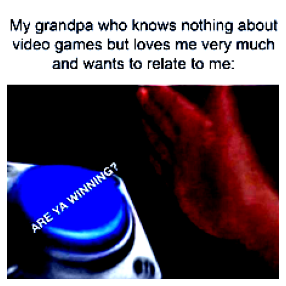

In [ ]:
show_image(im)